100.0%
100.0%
100.0%
100.0%


数据集加载完成！
开始训练...
Epoch 1/10: Train Loss: 0.4117, Train Acc: 0.880, Test Acc: 0.952
Epoch 2/10: Train Loss: 0.0891, Train Acc: 0.974, Test Acc: 0.978
Epoch 3/10: Train Loss: 0.0596, Train Acc: 0.982, Test Acc: 0.982
Epoch 4/10: Train Loss: 0.0443, Train Acc: 0.986, Test Acc: 0.984
Epoch 5/10: Train Loss: 0.0351, Train Acc: 0.989, Test Acc: 0.975
Epoch 6/10: Train Loss: 0.0283, Train Acc: 0.991, Test Acc: 0.988
Epoch 7/10: Train Loss: 0.0242, Train Acc: 0.993, Test Acc: 0.985
Epoch 8/10: Train Loss: 0.0195, Train Acc: 0.994, Test Acc: 0.965
Epoch 9/10: Train Loss: 0.0167, Train Acc: 0.995, Test Acc: 0.987
Epoch 10/10: Train Loss: 0.0130, Train Acc: 0.996, Test Acc: 0.986


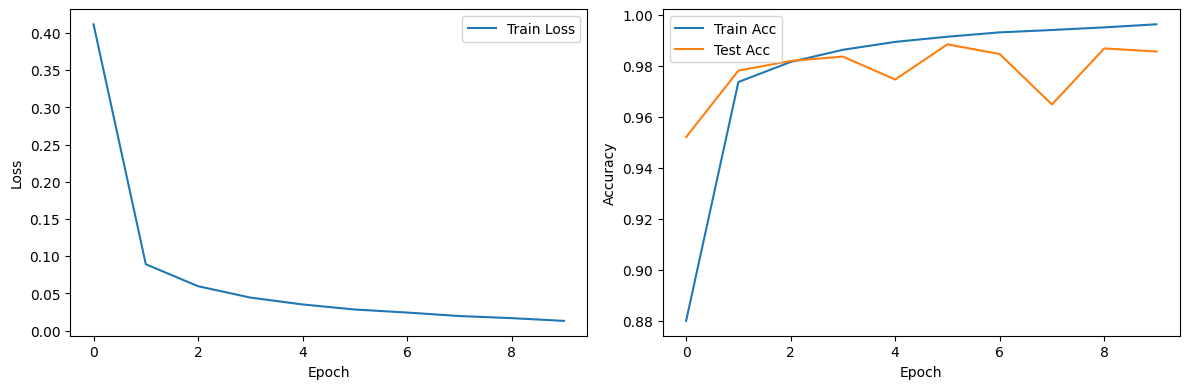

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os


# 1. 加载MNIST数据集，并返回训练集和测试集的数据加载器
def load_data_mnist(batch_size):  # batch_size (int): 每个批次的样本数量
    transform = transforms.Compose([
        transforms.ToTensor(),  # 将PIL图像转换为PyTorch张量
        transforms.Normalize((0.1307,), (0.3081,))  # # MNIST的标准归一化参数(均值=0.1307, 标准差=0.3081)
    ])
    # 定义数据预处理转换
    train_data = datasets.MNIST('./data', train=True, download=True,
                                transform=transform)  # 四个参数的含义：数据存储路径，加载训练集，如果不存在则下载，应用定义的数据转换
    test_data = datasets.MNIST('./data', train=False, download=True,
                               transform=transform)  # 四个参数的含义：数据存储路径，加载测试集，如果不存在则下载，应用定义的数据转换
    print("数据集加载完成！")
    return (
        DataLoader(train_data, batch_size, shuffle=True, num_workers=2),  # 训练集数据加载器(打乱顺序，使用2个工作进程)
        DataLoader(test_data, batch_size, shuffle=False, num_workers=2)  # 测试集数据加载器(不打乱顺序，使用2个工作进程)
    )


# 2. 模型定义 - 卷积神经网络模型 (替换原来的SimpleNN)
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 定义两个卷积层：
        self.conv1 = nn.Conv2d(1, 10, 5)  # 第一个卷积层: 输入通道1, 输出通道10, 卷积核5x5
        self.conv2 = nn.Conv2d(10, 20, 3)  # 第二个卷积层: 输入通道10, 输出通道20, 卷积核3x3
        # 定义两个全连接层：
        self.fc1 = nn.Linear(20 * 10 * 10, 500)  # 第一个全连接层: 输入2000, 输出500
        self.fc2 = nn.Linear(500, 10)  # 第二个全连接层: 输入500, 输出10

    def forward(self, x):  # x 为输入数据，形状为 batch×1×28×28
        out = self.conv1(x)  # 将 x 输入第一个卷积层
        out = torch.relu(out)  # 运用激活函数 relu
        out = torch.max_pool2d(out, 2, 2)  # 2x2最大池化
        out = self.conv2(out)  # 将 x 输入第二个卷积层
        out = torch.relu(out)  # 运用激活函数 relu
        out = out.view(out.size(0), -1)  # 扁平化以送入全连接层
        out = self.fc1(out)  # 将 x 输入第一个全连接层
        out = torch.relu(out)
        out = self.fc2(out)  # 将 x 输入第二个全连接层
        return out


# 3. 训练神经网络模型 并评估其性能
def train_model(net, train_iter, test_iter, num_epochs=10, lr=0.1):
    # 初始化优化器和损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  # 使用随机梯度下降优化器
    criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数

    train_loss_list = []  # 记录每个epoch的训练损失
    train_acc_list = []  # 记录每个epoch的训练准确率
    test_acc_list = []  # 记录每个epoch的测试准确率

    print("开始训练...")
    for epoch in range(num_epochs):
        total_loss, total_correct, total_samples = 0, 0, 0  # 初始化统计变量

        # 训练阶段
        for X, y in train_iter:
            output = net(X)  # 计算模型输出
            loss = criterion(output, y)  # 计算损失
            optimizer.zero_grad()  # 清空梯度缓存
            loss.backward()  # 计算梯度
            optimizer.step()  # 更新参数

            total_loss += loss.item()  # 累计损失
            total_correct += (output.argmax(dim=1) == y).sum().item()  # 累计正确预测数
            total_samples += y.size(0)  # 累计样本数

        # 计算训练指标
        train_loss = total_loss / len(train_iter)  # 计算平均训练损失
        train_acc = total_correct / total_samples  # 计算训练准确率

        # 测试阶段
        test_correct, test_samples = 0, 0
        with torch.no_grad():  # 禁用梯度计算
            for X, y in test_iter:
                output = net(X)
                test_correct += (output.argmax(dim=1) == y).sum().item()
                test_samples += y.size(0)
        test_acc = test_correct / test_samples

        # 记录指标
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.3f}, '
              f'Test Acc: {test_acc:.3f}')

    """可视化结果"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # 设置随机种子保证可重复性
    torch.manual_seed(42)

    # 参数设置
    batch_size = 256
    num_epochs = 10
    learning_rate = 0.1

    # 加载数据
    train_iter, test_iter = load_data_mnist(batch_size)

    # 初始化模型
    model = ConvNet()

    # 开始训练
    train_model(model, train_iter, test_iter, num_epochs, learning_rate)

